# Deep Face Detection Model

In [1]:
# !pip install labelme tensorflow opencv-python matplotlib albumentations
# !pip install opencv-contrib-python

### 1.2 Collect  Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('practices/Deep-Learning/model/data')
number_images = 30

In [4]:
# cap = cv2.VideoCapture(0)  # Ensure 0 is the correct device index
# if not cap.isOpened():
#     print("Cannot access the camera")
# else:
#     print("Camera accessed successfully")

In [5]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting Image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(1)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

## !Annotate Images with LabelMe

In [6]:
# !labelme

# Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2024-11-29 13:47:44.747932: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 13:47:44.751461: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 13:47:44.760736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732888064.775727   16983 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732888064.780194   16983 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 13:47:44.797310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 2.2 Limit GPU Memory Growth

In [8]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 2.3 Load Image into TF Data Pipeline

In [10]:
images = tf.data.Dataset.list_files('./model/data/test/images/*.jpg', shuffle=False)

In [11]:
images.as_numpy_iterator().next()

b'./model/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'

In [12]:
def load_image(X):
    byte_img = tf.io.read_file(X)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [15]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View Raw Images With Matplotlib

In [16]:
image_generator = images.batch(4).as_numpy_iterator()

In [17]:
plot_images = image_generator.next()

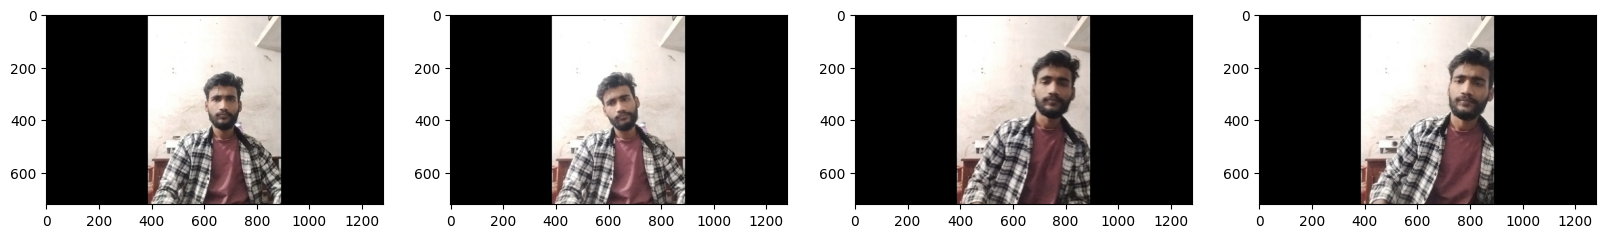

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually Split Data into train test and val

In [19]:
113 * .7 #79 to train

79.1

In [ ]:
113 * .15 # 17 and 17 to test and val

16.95

## 3.2 Move the Matching Labels

In [ ]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath, new_filepath)

# Albumentations

In [20]:
import albumentations as alb

In [21]:
img = cv2.imread(os.path.join('./model/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'))

In [22]:
img.shape

(720, 1280, 3)

In [23]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1280, height=720),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotaition with OpenCv and JSON

In [24]:
img = cv2.imread(os.path.join('./model/data/train/images/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.jpg'))

In [25]:
with open(os.path.join('./model/data/train/labels/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.json'), 'r') as f:label = json.load(f)

In [26]:
label['shapes'][0]['points']

[[550.9756097560976, 206.3414634146342],
 [749.7560975609756, 446.5853658536586]]

### 4.3 Extract Cordintaes and Rescale to Match image Resolution

In [27]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [28]:
coords

[550.9756097560976, 206.3414634146342, 749.7560975609756, 446.5853658536586]

In [29]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [30]:
coords

[np.float64(0.43044969512195125),
 np.float64(0.2865853658536586),
 np.float64(0.5857469512195121),
 np.float64(0.6202574525745258)]

### 4.4 Apply Augmentations and View Results

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [32]:
augmented['image'].shape

(720, 1280, 3)

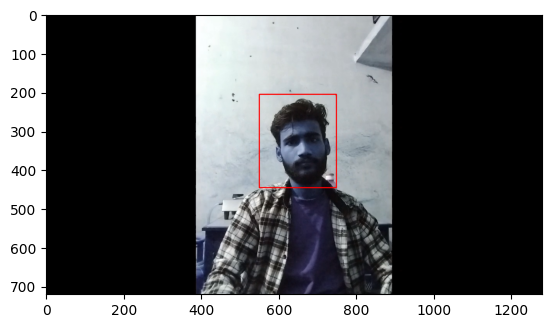

In [33]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1280,720]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)),
              (255, 0, 0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [35]:
base_path = './model/data'
output_path = './model/aug_data'

for partition in ['train', 'test', 'val']:
    partition_path = os.path.join(base_path, partition)
    images_path = os.path.join(partition_path, 'images')
    labels_path = os.path.join(partition_path, 'labels')

    aug_images_path = os.path.join(output_path, partition, 'images')
    aug_labels_path = os.path.join(output_path, partition, 'labels')

    # Create required directories if they don't exist
    os.makedirs(aug_images_path, exist_ok=True)
    os.makedirs(aug_labels_path, exist_ok=True)

    for image_file in os.listdir(images_path):
        image_path = os.path.join(images_path, image_file)
        img = cv2.imread(image_path)

        if img is None:
            print(f"Could not read image: {image_file}")
            continue

        # Default bounding box coordinates
        coords = [0, 0, 0.0001, 0.00001]
        label_file = f'{os.path.splitext(image_file)[0]}.json'
        label_path = os.path.join(labels_path, label_file)

        # Load label if it exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            if 'shapes' in label and len(label['shapes']) > 0:
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try:
            # Generate augmentations
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

                # Save augmented image
                aug_image_file = f"{os.path.splitext(image_file)[0]}.{x}.jpg"
                cv2.imwrite(os.path.join(aug_images_path, aug_image_file), augmented['image'])

                # Prepare annotation
                annotation = {'image': aug_image_file}

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                # Save annotation
                aug_label_file = f"{os.path.splitext(image_file)[0]}.{x}.json"
                with open(os.path.join(aug_labels_path, aug_label_file), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(f"Error processing {image_file}: {e}")


# 6. Prepare Labels

### 6.1 Build Label Loading Function